In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import MAPE
from tensorflow.keras import callbacks
from google.cloud import storage
import joblib

def subsample_sequence(df, length):
    '''
    function that return a random slice of features and targets
    len(X) = lenght and len(y) = 3
    '''
    last_possible = df.shape[0] - length - 3
    random_start = np.random.randint(0, last_possible)
    X = df[random_start: random_start+length].values
    y = df.iloc[random_start+length:random_start+length+3][['price_usd']]
    return X, y

def get_X_y(df, length_of_observations):
    '''
    function that returns a list of random slices of features and targets
    len(X[0]) = lenght and len(y[0]) = 3
    '''
    X, y = [], []
    for length in length_of_observations:
        xi, yi = subsample_sequence(df, length)
        X.append(xi)
        y.append(yi)
    return X, y

def split_tr_te(df, horizon=3, ratio=0.95):
    '''
    function that returns a training and test set
    arguments are:
    the horizon of prediction
    the ratio of the train/test split
    '''
    # the gap to avoid data leakage
    # gap = horizon - 1
    # len_ = int(ratio*df.shape[0])
    # data_train = df[:len_]
    # data_test = df[len_+gap:]
    # return data_train, data_test
    
    len_ = int(ratio*df.shape[0])
    data_train = df[:len_]
    data_test = df[len_+1:]
    return data_train, data_test
    
    # len_ = 1696
    # data_train = df[:len_]
    # data_test = df[len_:]
    # return data_train, data_test

def extract_xy_tr_te(train,
                     test,
                     train_splits = 3000,
                     train_time_min = 30,
                     train_time_max = 180):
    '''
    function returns a serie of train and test data
    train splits is the number of selections of our dataset
    train_time_min is the minimum number of days that are randomly choosen by the get_X_y function
    train_time_max is the maximum number of days that are randomly choosen by the get_X_y function
    '''
    length_of_observations = np.random.randint(train_time_min, train_time_max, train_splits)
    X_train, y_train = get_X_y(train, length_of_observations)
    #length_of_observations = np.random.randint(train_time_min, train_time_max, train_splits)
    #X_test, y_test = get_X_y(test, length_of_observations)
    return X_train, y_train #, X_test, y_test

def padding_seq(train):
    '''
    function that return the padded version of the train dataset
    to uniform the size of the model imput
    '''
    return pad_sequences(train, dtype='float32', value=-1)

def baseline_model(X_train_pad, y_train):
    '''
    function that return a trained baseline model and its fitting history
    and save locally the trained model file basemodel.joblib
    '''
    normalizer = Normalization()
    normalizer.adapt(X_train_pad)
    model = Sequential()
    model.add(normalizer)
    model.add(layers.Masking(mask_value=-1))
    model.add(layers.LSTM(40, activation='tanh')) # GS N UNITS
    model.add(layers.Dense(40, activation='relu')) # GS N UNITS
    model.add(layers.Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer=RMSprop(learning_rate=0.01), metrics=MAPE)
    es = callbacks.EarlyStopping(patience=6, restore_best_weights=True)
    history = model.fit(X_train_pad,
                np.array(y_train),
                epochs=30,
                batch_size=64,
                validation_split=0.3,
                callbacks=[es],
                verbose=1)
    joblib.dump(model, 'basemodel.joblib')
    return model, history

def plot_history(history, title='', axs=None, exp_name=""):
    '''
    return the loss and metric plots of train and test fit process
    '''
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label = 'train' + exp_name)
    ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
    ax1.set_ylim(0., 100000)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['mean_absolute_percentage_error'], label='train mape'  + exp_name)
    ax2.plot(history.history['val_mean_absolute_percentage_error'], label='val mape'  + exp_name)
    ax1.set_ylim(0., 100000)
    ax2.set_title('mape')
    ax2.legend()
    return (ax1, ax2)

def pred_3d_price(model, test):
    '''
    return the prediction of three days after the test data
    '''
    return model.predict(test)

# PARAMETERS FOR GCP BASEMODEL UPLOAD

STORAGE_LOCATION = 'models/basemodel.joblib'
BUCKET_NAME='crypto913'

def upload_model_to_gcp():
    '''
    function that upload the trained model to gcp
    '''
    client = storage.Client()
    bucket = client.bucket(BUCKET_NAME)
    blob = bucket.blob(STORAGE_LOCATION)
    blob.upload_from_filename('basemodel.joblib')


In [14]:
data_dl.shape
1778-80

1698

In [31]:
data_dl = pd.read_csv('../raw_data/data_advanced.csv') # TO RUN LOCALLY

data_dl.shape
data_dl.set_index('datetime', inplace=True)
data_dl.drop(columns='Unnamed: 0', inplace=True)
data_train, data_test = split_tr_te(data_dl)
X_train, y_train = extract_xy_tr_te(train=data_train,
                                    test=data_test)
X_train_pad = padding_seq(X_train)
model, history = baseline_model(X_train_pad, y_train)

Epoch 1/30
33/33 [==============================] - ETA: 0s - loss: 2521270.0000 - mean_absolute_percentage_error: 68.0231

KeyboardInterrupt: 

In [5]:
X_predict = data_dl.tail(80)
y_pred = pred_3d_price(model, X_predict)
y_pred

3/3 [==============================] - 1s 5ms/step


array([[2273.512 ],
       [1262.551 ],
       [1578.9622]], dtype=float32)

(<AxesSubplot:title={'center':'loss'}>, <AxesSubplot:title={'center':'mape'}>)

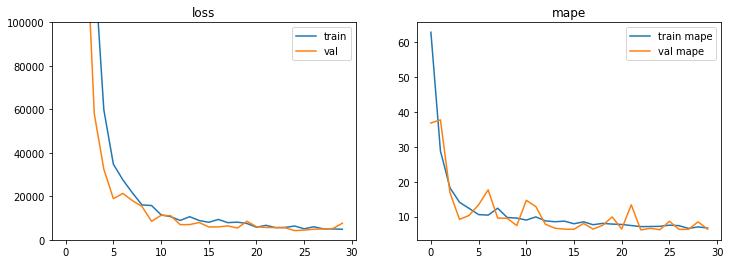

In [11]:
plot_history(history, title='', axs=None, exp_name="")

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(data_dl['price_usd'], label="Ethereum Price")
plt.plot(test['ds'], test['y'], label="Test")
plt.plot(forecast[-horizon:]['ds'], forecast[-horizon:]['yhat'], label="predictions")
plt.legend(loc="best")
plt.show()

In [1]:

#data_dl['datetime'] = pd.to_datetime(data_dl['datetime'])
#data_dl.set_index('datetime', inplace=True)
#data_train, data_test = split_tr_te(data_dl)
#X_train, y_train, X_test, y_test = extract_xy_tr_te(train=data_train,
#                                                      test=data_test)
# X_train_pad = padding_seq(X_train)
# model, history = baseline_model(X_train_pad, y_train)
# X_predict = data_dl.tail(80)
# y_pred = pred_3d_price(model, X_predict)

# upload_model_to_gcp()
# print(y_pred)

In [5]:
import datetime

e = datetime.datetime.now()
date = f'{string(e.year)[-2]}'
print(date)
print ("Current date and time = %s" % e)
print ("Today's date:  = %s/%s/%s" % (e.day, e.month, e.year))
print ("The time is now: = %s:%s:%s" % (e.hour, e.minute, e.second))

NameError: name 'string' is not defined